# 0. Import libraries

In [1]:
import pandas as pd
import numpy as np
from optbinning import BinningProcess

(CVXPY) Nov 04 09:05:10 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Nov 04 09:05:10 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


# 1. Data Cleaning & Outliers Handling

## Import & clean data

In [2]:
data = pd.read_csv(r'telecom_churn_data.csv')
data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [3]:
# Summary statistics of numerical columns
print(data.describe())

       mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   9.999900e+04    99999.0         98981.0         98981.0   
mean    7.001207e+09      109.0             0.0             0.0   
std     6.956694e+05        0.0             0.0             0.0   
min     7.000000e+09      109.0             0.0             0.0   
25%     7.000606e+09      109.0             0.0             0.0   
50%     7.001205e+09      109.0             0.0             0.0   
75%     7.001812e+09      109.0             0.0             0.0   
max     7.002411e+09      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8        arpu_9  \
count         98981.0  99999.000000  99999.000000  99999.000000  99999.000000   
mean              0.0    282.987358    278.536648    279.154731    261.645069   
std               0.0    328.439770    338.156291    344.474791    341.998630   
min               0.0  -2258.709000  -2014.045000   -945.808000  -1899.5

- I drop some columns below because each of them store the same data for all row (e.g circle_id are always 109, last_date_of_month_6 are always 6/30/2014, ...)
- After that, all the remaining data are numeric. Therefore I fill 0 to all missing data

In [4]:
# Drop non-essential columns
columns_to_drop = [
    'circle_id', 'last_date_of_month_6', 'last_date_of_month_7', 
    'last_date_of_month_8', 'last_date_of_month_9',
    'date_of_last_rech_6', 'date_of_last_rech_7',
    'date_of_last_rech_8', 'date_of_last_rech_9',
    'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 
    'date_of_last_rech_data_8', 'date_of_last_rech_data_9'
]

data = data.drop(columns=columns_to_drop)

# Fill all missing values with 0
data = data.fillna(0)
data.head()

,mobile_number,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,0.0,0.0,0.0,197.385,214.816,213.803,21.100,0.00,0.00,...,0,1.0,1.0,1.0,0.0,968,30.4,0.0,101.20,3.58
1,7001865778,0.0,0.0,0.0,34.047,355.074,268.321,86.285,24.11,78.68,...,0,0.0,1.0,1.0,0.0,1006,0.0,0.0,0.00,0.00
2,7001625959,0.0,0.0,0.0,167.690,189.058,210.226,290.714,11.54,55.24,...,0,0.0,0.0,0.0,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,0.0,0.0,0.0,221.338,251.102,508.054,389.500,99.91,54.39,...,0,0.0,0.0,0.0,0.0,2491,0.0,0.0,0.00,0.00
4,7000142493,0.0,0.0,0.0,261.636,309.876,238.174,163.426,50.31,149.44,...,0,0.0,0.0,0.0,0.0,1526,0.0,0.0,0.00,0.00


## Handle data outliers
- Set the mobile_number as data index
- Calculate the IQR for each feature to identify outliers.
- Cap values at the 5th and 95th percentiles for selected features, which helps retain data while limiting the impact of extreme values.

In [5]:
data.set_index('mobile_number', inplace=True)

# Define a function to handle outliers by capping at percentiles
def handle_outliers(df, columns, lower_percentile=0.05, upper_percentile=0.95):
    for col in columns:
        lower_bound = df[col].quantile(lower_percentile)
        upper_bound = df[col].quantile(upper_percentile)
        # Cap the outliers
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

# Apply outlier handling
data = handle_outliers(data, data.columns)

# Check data statistics after handling outliers
print(data[data.columns].describe())

       loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou        arpu_6  \
count         99999.0         99999.0         99999.0  99999.000000   
mean              0.0             0.0             0.0    263.041936   
std               0.0             0.0             0.0    225.103233   
min               0.0             0.0             0.0      1.500000   
25%               0.0             0.0             0.0     93.411500   
50%               0.0             0.0             0.0    197.704000   
75%               0.0             0.0             0.0    371.060000   
max               0.0             0.0             0.0    829.488200   

             arpu_7        arpu_8        arpu_9  onnet_mou_6   onnet_mou_7  \
count  99999.000000  99999.000000  99999.000000  99999.00000  99999.000000   
mean     258.099359    257.892617    241.041548    100.57472    100.672025   
std      225.569991    228.447081    226.125278    157.61316    161.119405   
min        0.750000      0.000000      0.000000 

# 2. Explanatory Data Analysis (EDA)

## Distribution of Recharge Amount in June and July

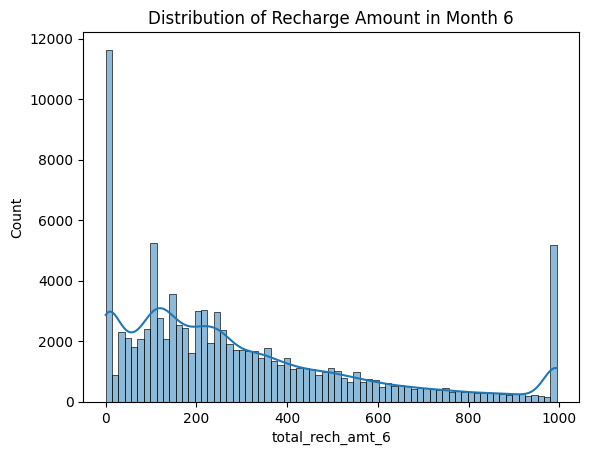

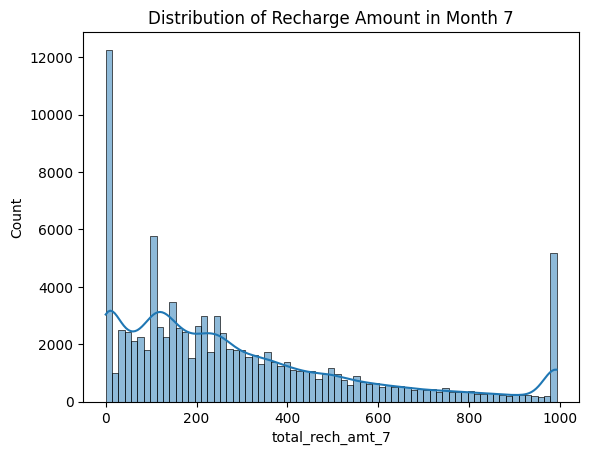

In [6]:
# Plot distributions of primary usage metrics
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data['total_rech_amt_6'], kde=True)
plt.title('Distribution of Recharge Amount in Month 6')
plt.show()

sns.histplot(data['total_rech_amt_7'], kde=True)
plt.title('Distribution of Recharge Amount in Month 7')
plt.show()

## Trend Analysis of Total Recharge Patterns
Checking if there are consistent patterns in recharge behavior that distinguish churners from non-churners.\
Method: Compare total recharge amounts over time (e.g., months 6, 7, and 8) between churners and non-churners.\
A decline in total recharge amount might indicate churn.

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12352\1818230765.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['churn'] = np.where(


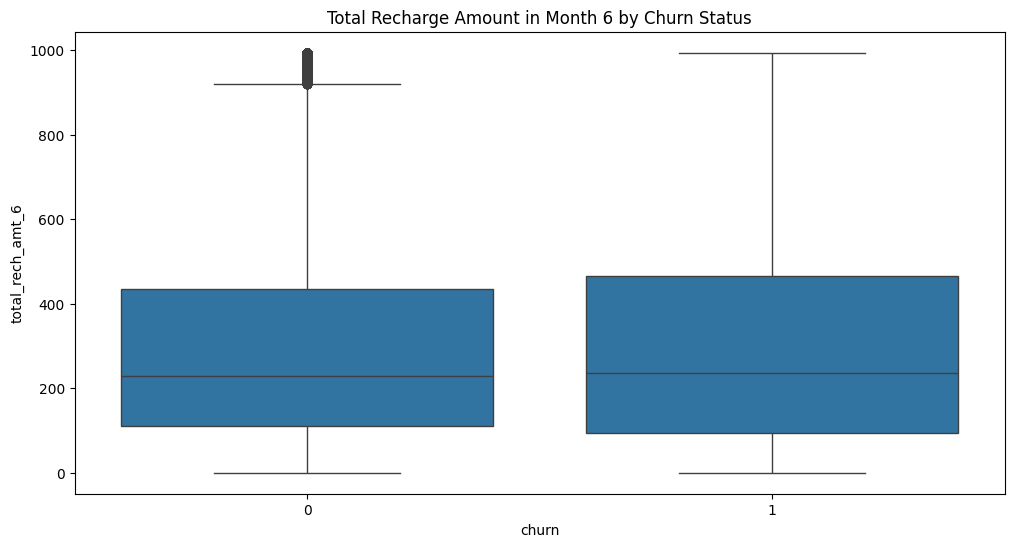

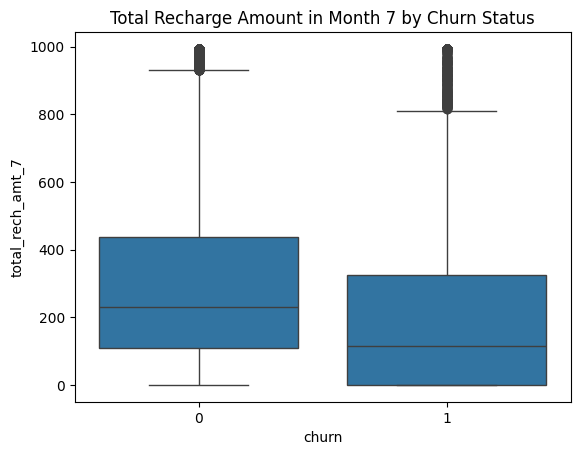

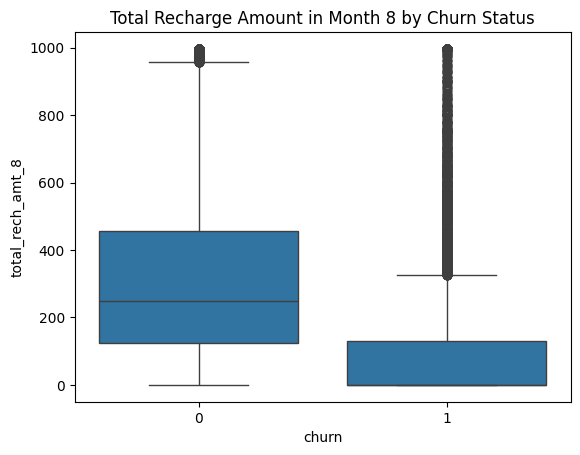

In [7]:
# Add the 'churn' column if it's already created
data['churn'] = np.where(
    (data['total_ic_mou_9'] == 0) &
    (data['total_og_mou_9'] == 0) &
    (data['vol_2g_mb_9'] == 0) &
    (data['vol_3g_mb_9'] == 0), 1, 0
)

# Compare recharge trends for churners vs. non-churners
plt.figure(figsize=(12, 6))
sns.boxplot(x='churn', y='total_rech_amt_6', data=data)
plt.title('Total Recharge Amount in Month 6 by Churn Status')
plt.show()

sns.boxplot(x='churn', y='total_rech_amt_7', data=data)
plt.title('Total Recharge Amount in Month 7 by Churn Status')
plt.show()

sns.boxplot(x='churn', y='total_rech_amt_8', data=data)
plt.title('Total Recharge Amount in Month 8 by Churn Status')
plt.show()

## Trend Analysis of Average Recharge Patterns
Checking and looking for any time-based trends such as differences in average recharge behavior by month.\
A decline in average recharge amounts over recent months might signal disengagement, which can precede churn.

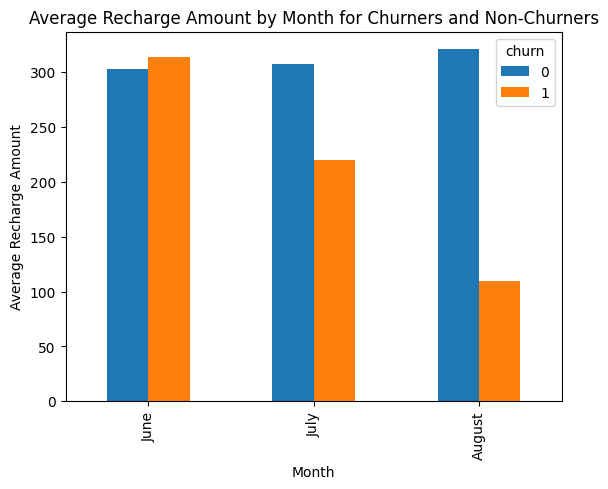

In [8]:
avg_rech_amt_by_month = data.groupby(['churn']).agg({
    'total_rech_amt_6': 'mean',
    'total_rech_amt_7': 'mean',
    'total_rech_amt_8': 'mean'
}).T

# Rename the index to show the appropriate month numbers
avg_rech_amt_by_month.index = ['June', 'July', 'August']

# Plot average recharge amount per month for churners vs. non-churners
avg_rech_amt_by_month.plot(kind='bar')
plt.title('Average Recharge Amount by Month for Churners and Non-Churners')
plt.xlabel('Month')
plt.ylabel('Average Recharge Amount')
plt.show()

## Usage Pattern Analysis
Investigating whether changes in call usage (incoming/outgoing, local/roaming) predict churn. Often, churners show a drop in usage prior to churning.\
Method: Plot call minutes over time and compare them for churners vs. non-churners.\
A decline in usage (e.g., minutes call or data) over recent months might signal disengagement, which can precede churn.

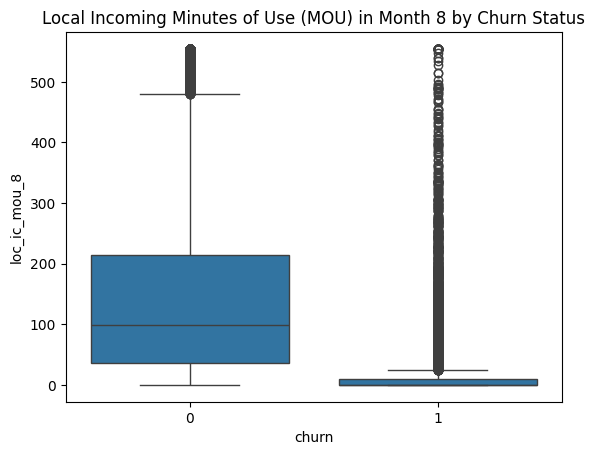

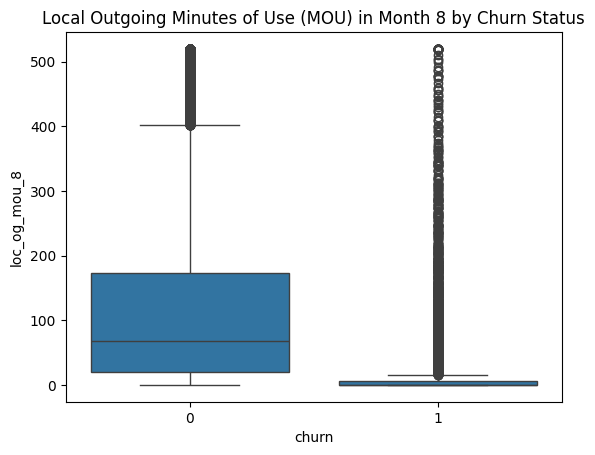

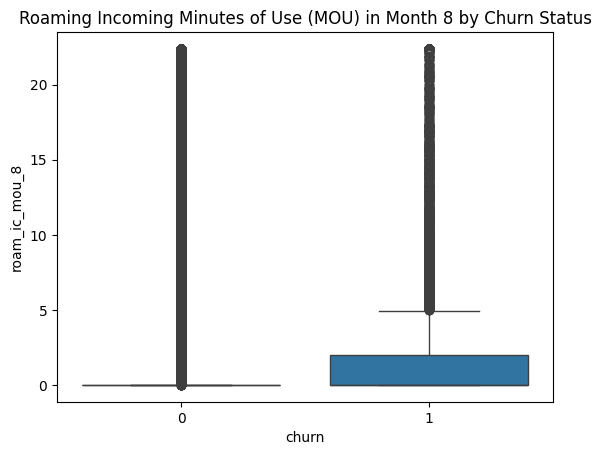

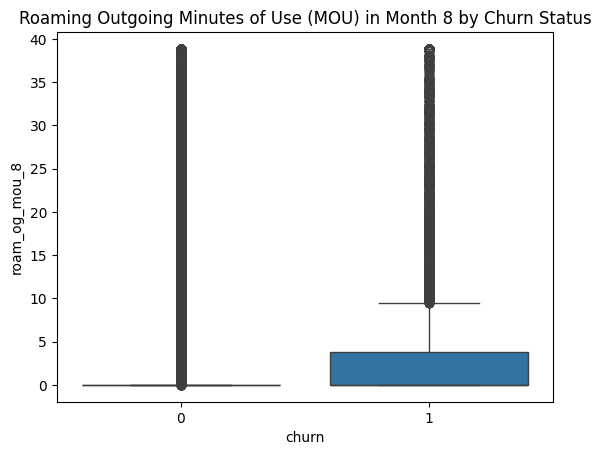

In [9]:
# Local incoming minutes comparison
sns.boxplot(x='churn', y='loc_ic_mou_8', data=data)
plt.title('Local Incoming Minutes of Use (MOU) in Month 8 by Churn Status')
plt.show()

# Local outgoing minutes comparison
sns.boxplot(x='churn', y='loc_og_mou_8', data=data)
plt.title('Local Outgoing Minutes of Use (MOU) in Month 8 by Churn Status')
plt.show()

# Roaming minutes comparison
sns.boxplot(x='churn', y='roam_ic_mou_8', data=data)
plt.title('Roaming Incoming Minutes of Use (MOU) in Month 8 by Churn Status')
plt.show()

sns.boxplot(x='churn', y='roam_og_mou_8', data=data)
plt.title('Roaming Outgoing Minutes of Use (MOU) in Month 8 by Churn Status')
plt.show()

## Revenue Contribution Analysis
Checking if high-value customers are less likely to churn compared to low-value customers, by analyzing metrics like ARPU (Average Revenue Per User).\
Customers with low ARPU are more likely to churn, possibly due to perceived lack of value.

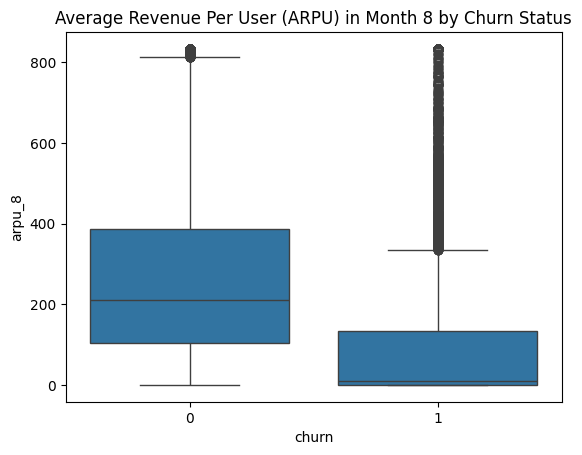

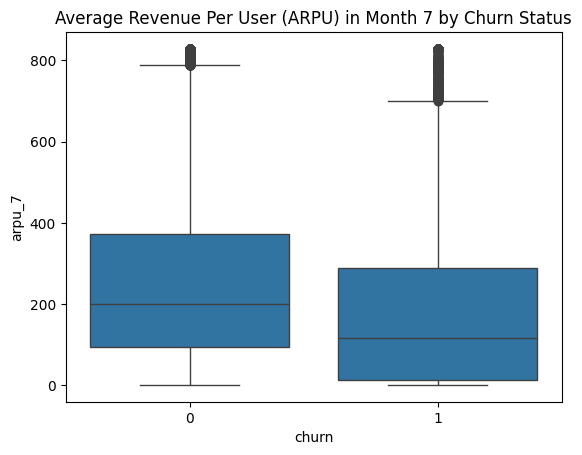

In [10]:
# ARPU analysis for churners vs non-churners
sns.boxplot(x='churn', y='arpu_8', data=data)
plt.title('Average Revenue Per User (ARPU) in Month 8 by Churn Status')
plt.show()

# Check revenue trends in earlier months as well
sns.boxplot(x='churn', y='arpu_7', data=data)
plt.title('Average Revenue Per User (ARPU) in Month 7 by Churn Status')
plt.show()

## Correlation Analysis of Potential Features
Different features correlate with each other and with the churn variable. High correlation among features might suggest multicollinearity issues \
Identifying high correlation can help us address multicollinearity, especially important if we use logistic regression.

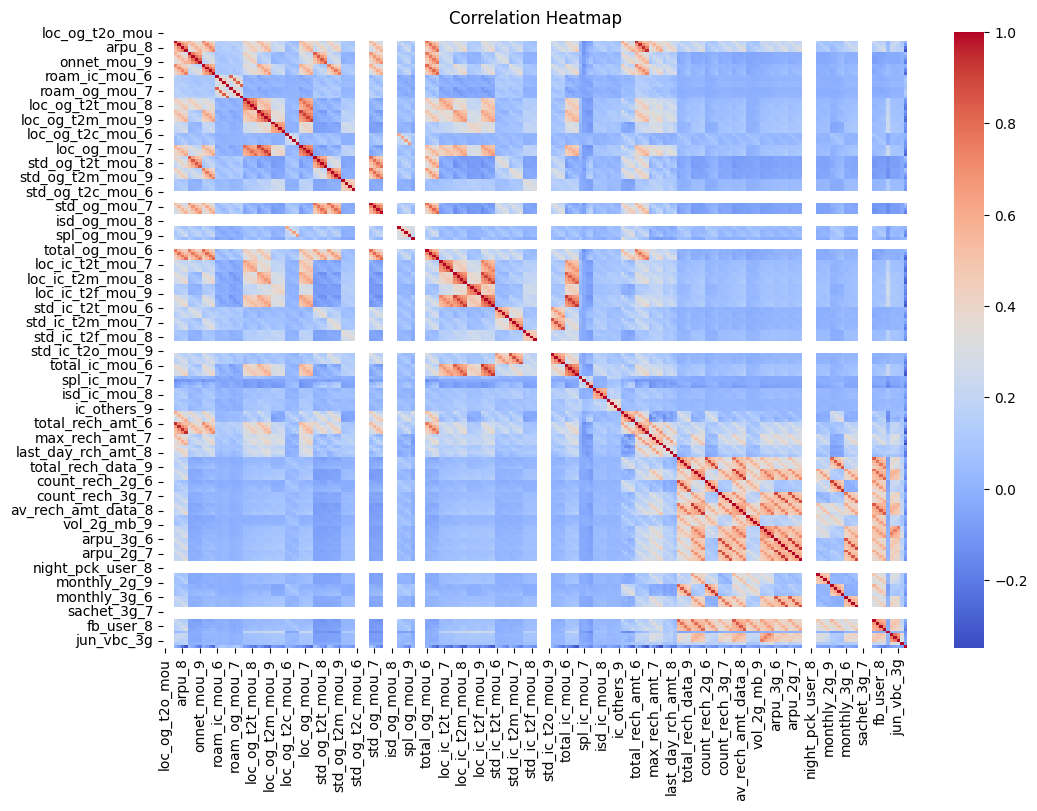

Correlation with churn:
churn               1.000000
roam_og_mou_8       0.128660
roam_og_mou_7       0.127379
roam_ic_mou_8       0.104673
roam_ic_mou_7       0.103247
                      ...   
night_pck_user_9         NaN
sachet_3g_6              NaN
sachet_3g_7              NaN
sachet_3g_8              NaN
sachet_3g_9              NaN
Name: churn, Length: 213, dtype: float64


In [11]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False)
plt.title('Correlation Heatmap')
plt.show()

# Correlation with churn
churn_corr = data.corr()['churn'].sort_values(ascending=False)
print("Correlation with churn:")
print(churn_corr)

# 3. Data preparation steps

In [12]:
# Step 1: Identify High-Value Customers
data['avg_rech_amt_good_phase'] = (data['total_rech_amt_6'] + data['total_rech_amt_7']) / 2
X = data['avg_rech_amt_good_phase'].quantile(0.7)
data['high_value_customer'] = np.where(data['avg_rech_amt_good_phase'] >= X, 1, 0)

# Filter high-value customers, making an independent copy to avoid warnings
high_value_data = data[data['high_value_customer'] == 1].copy()

# Step 2: Tag Churners based on zero usage in month 9
high_value_data.loc[:, 'churn'] = np.where(
    (high_value_data['total_ic_mou_9'] == 0) &
    (high_value_data['total_og_mou_9'] == 0) &
    (high_value_data['vol_2g_mb_9'] == 0) &
    (high_value_data['vol_3g_mb_9'] == 0), 1, 0
)

# Step 3: Drop month 9 columns to prevent data leakage
churn_data = high_value_data.drop([col for col in high_value_data.columns if '_9' in col], axis=1)
churn_data.head()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12352\2132675645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['avg_rech_amt_good_phase'] = (data['total_rech_amt_6'] + data['total_rech_amt_7']) / 2
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12352\2132675645.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['high_value_customer'] = np.where(data['avg_rech_amt_good_phase'] >= X, 1, 0)


,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,churn,avg_rech_amt_good_phase,high_value_customer
mobile_number,,,,,,,,,,,,,,,,,,,,,
7000701601,0.0,0.0,0.0,829.4882,828.3572,833.3033,57.840,54.68,52.29,453.43,...,0.0,0.0,802.0,57.74,19.380,18.74,0.0,1,892.0,1
7001524846,0.0,0.0,0.0,378.7210,492.2230,137.3620,413.690,351.03,35.08,94.66,...,1.0,1.0,315.0,21.03,450.705,122.16,0.0,0,519.0,1
7002191713,0.0,0.0,0.0,492.8460,205.6710,593.2600,501.760,108.39,534.24,413.31,...,0.0,1.0,2607.0,0.00,0.000,0.00,0.0,0,380.0,1
7000875565,0.0,0.0,0.0,430.9750,299.8690,187.8940,50.510,74.01,70.61,296.29,...,0.0,0.0,511.0,0.00,2.450,21.89,0.0,0,459.0,1
7000187447,0.0,0.0,0.0,690.0080,18.9800,25.4990,594.285,9.28,7.79,61.64,...,0.0,0.0,667.0,0.00,0.000,0.00,0.0,0,408.0,1


Class Distribution (%):
churn
0    91.359835
1     8.640165
Name: proportion, dtype: float64


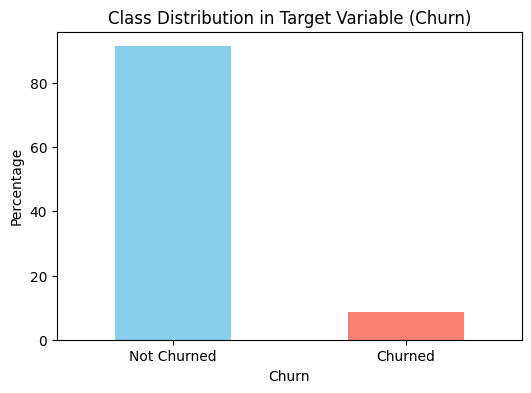

In [13]:
# Split into train and test
from sklearn.model_selection import train_test_split
# Separate features and target variable
X = churn_data.drop(columns=['churn'])
y = churn_data['churn']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Calculate the class distribution in the target variable
churn_counts = churn_data['churn'].value_counts(normalize=True) * 100
print("Class Distribution (%):")
print(churn_counts)

# Plot the distribution for a visual overview
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
churn_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution in Target Variable (Churn)')
plt.xlabel('Churn')
plt.ylabel('Percentage')
plt.xticks(ticks=[0, 1], labels=['Not Churned', 'Churned'], rotation=0)
plt.show()

According to the distribution graph, since the rate of churn is typically low (about 8.64%), this is class imbalance. \
Therefore, when training the model in section 4, I need to input balanced class weight flag for the training function to handle it.

# 4. VIF Feature Engineering

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_train = X_train.select_dtypes(include=['number'])
# If necessary, drop any rows with NaN values
X_train = X_train.dropna()

# Calculating VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X_train.columns
vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Convert VIF column to numeric, setting errors='coerce' to handle any non-numeric values
vif_data['VIF'] = pd.to_numeric(vif_data['VIF'], errors='coerce')

# Display features with VIF > 10 (indicating high multicollinearity)
high_vif = vif_data[vif_data['VIF'] > 10]

# Show the result
high_vif

c:\Master of Data Science\Docs\Python\env\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Master of Data Science\Docs\Python\env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
5,arpu_8,11.139893
6,onnet_mou_6,16.631573
7,onnet_mou_7,23.258547
8,onnet_mou_8,21.420441
9,offnet_mou_6,14.338468
...,...,...
144,sachet_2g_6,18.925173
145,sachet_2g_7,38.899245
146,sachet_2g_8,48.671198
161,avg_rech_amt_good_phase,inf


# 5. Model building

## Logistic Regression

Since we are doing binary classification to predict churned or not churned, Logistic regression is a must-have method for this scenario

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Train logistic regression with class weights
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions and evaluation on test data
y_pred = log_reg.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred))
print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_pred))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.84      0.91      5484
           1       0.33      0.83      0.48       519

    accuracy                           0.84      6003
   macro avg       0.66      0.84      0.69      6003
weighted avg       0.93      0.84      0.87      6003

Logistic Regression AUC-ROC: 0.8368116601948706


c:\Master of Data Science\Docs\Python\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Random Forest
Random Forest is highly effective for accurate predictions and identifying key predictors in complex datasets, especially in scenarios with potential non-linearity and numerous features

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Train random forest with class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Predictions and evaluation on test data
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest AUC-ROC:", roc_auc_score(y_test, y_pred_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      5484
           1       0.79      0.44      0.56       519

    accuracy                           0.94      6003
   macro avg       0.87      0.71      0.77      6003
weighted avg       0.93      0.94      0.93      6003

Random Forest AUC-ROC: 0.7140003710215319


## Evaluation Metrics for both methods

In [17]:
from sklearn.metrics import roc_auc_score, f1_score

# Logistic Regression metrics
roc_auc_log = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
f1_log = f1_score(y_test, y_pred)

# Random Forest metrics
roc_auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
f1_rf = f1_score(y_test, y_pred_rf)

print("Logistic Regression AUC-ROC:", roc_auc_log)
print("Logistic Regression F1 Score:", f1_log)
print("Random Forest AUC-ROC:", roc_auc_rf)
print("Random Forest F1 Score:", f1_rf)

Logistic Regression AUC-ROC: 0.8983411542985796
Logistic Regression F1 Score: 0.47624309392265196
Random Forest AUC-ROC: 0.9275622620508215
Random Forest F1 Score: 0.5636588380716935


Overall Insights
- Random Forest Outperforms Logistic Regression: Based on both the AUC-ROC and F1 score, the Random Forest model performs better in distinguishing between churners and non-churners and handling the imbalanced data. It provides both higher discrimination (AUC-ROC) and a more balanced prediction (F1 score).
- Model Choice for Deployment: Given the higher AUC-ROC and F1 score, the Random Forest model appears to be the better choice for deployment if the goal is to accurately predict churn. This model would likely provide better results in real-world usage, especially in targeting high-risk customers.

# 6. Feature Importance Visualization

## Logistic Regression Coefficients

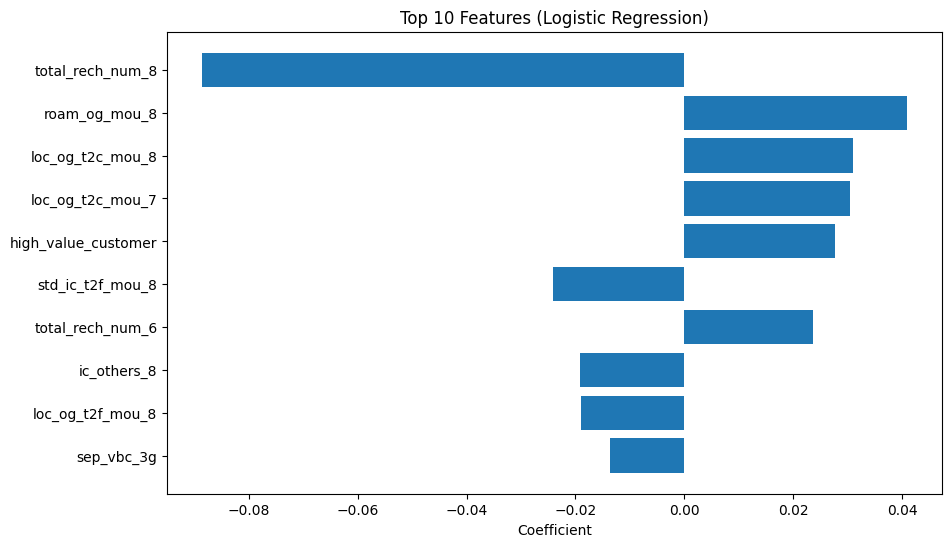

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Logistic regression feature importance (coefficients)
coefficients = log_reg.coef_[0]
features = X_train.columns

# Sort by absolute value to highlight most impactful features
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
coef_df['AbsCoefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'][:10], coef_df['Coefficient'][:10])
plt.xlabel('Coefficient')
plt.title('Top 10 Features (Logistic Regression)')
plt.gca().invert_yaxis()
plt.show()

- The positive coefficient on variables related to roaming and specific call usage (e.g., loc_og_t2c_mou_8, std_ic_t2f_mou_8) might indicate a segment of customers who use the network intensively in specific ways but are at a high risk of churning.
- High engagement in month 8 seems to reduce churn risk, suggesting that recency in recharges and usage plays an important role in retention.

## Random Forest Feature Importances

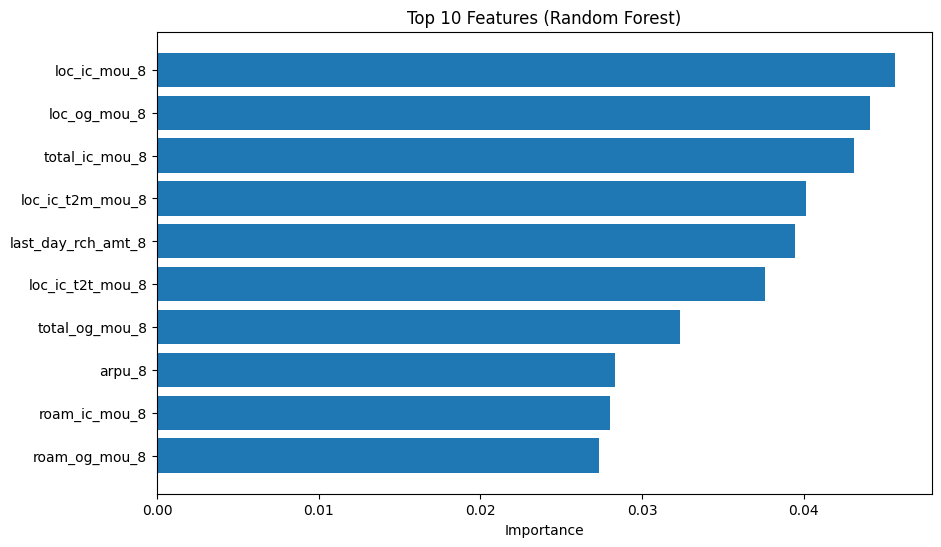

In [19]:
# Random forest feature importance
importances = rf.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort and plot top 10 features
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Features (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

While logistic regression highlighted features related to recharges and high-value customer indicators, the random forest model places more emphasis on minutes of use (MOU) metrics, covering a broader spectrum of incoming and outgoing call behaviors. This difference indicates that random forests capture nonlinear relationships more effectively, allowing for a wider range of feature influences.